<img src="img/GTK_Logo_Social Icon.jpg" align="left" height=125, width=125  style="margin:0px 15px"/> 
<img src="img/dataworks.jpeg" align="right" height=125, width=125  style="margin:0px 15px"/> 

# Supervised Learning Worksheet - Answers
This worksheet covers concepts relating to tuning a classifier.  For this example, we will be using the problem of identifying domains generated by Domain Generating Algorithms (DGA).  

Please raise your hand if you get stuck.  

## Import the Libraries
For this exercise, we will be using:
* Pandas (http://pandas.pydata.org/pandas-docs/stable/)
* Numpy (https://docs.scipy.org/doc/numpy/reference/)
* Matplotlib (http://matplotlib.org/api/pyplot_api.html)
* Scikit-learn (http://scikit-learn.org/stable/documentation.html)
* YellowBrick (http://www.scikit-yb.org/en/latest/)
* Seaborn (https://seaborn.pydata.org)
* Lime (https://github.com/marcotcr/lime)
* TPOT (https://epistasislab.github.io/tpot/)

In [18]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
import time
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
from scipy.stats import uniform as sp_rand
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
import matplotlib.pyplot as plt
import matplotlib
import lime
from tpot import TPOTClassifier
import joblib
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

## Prepare the Data
For this exercise, we are going to focus on building a pipeline and then tuning the resultant model, so we're going to use a simple model with only five features.

This workshop did not cover feature extraction and engineering, so we will just make your life easy and give you the data.  The features are:
* `length`: The character length of the domain.
* `digits`: The number of digits in the domain.
* `entropy`: The Shannon-entropy of the domain. (https://en.wikipedia.org/wiki/Entropy_(information_theory))
* `vowel-cons`: The ratio of vowels to consonants.
* `firstDigitIndex`:  The index of the first digit in the domain.  Defaults to zero if no digits are present
* `ngrams`: The normalized sum of 2-grams, 3-grams and 4-grams present in the domain.

This data set has 1000 of each class which is contained in the column `isDGA`.


In [2]:
df_final = pd.read_csv('data/dga_features_final_df.csv')
target = df_final['isDGA']
feature_matrix = df_final.drop(['isDGA'], axis=1)
feature_matrix.sample(5)

length  digits   entropy  vowel-cons  firstDigitIndex       ngrams
647       12       0  0.398590    0.200000                0   900.265657
1577      13       0  0.404863    0.625000                0  1249.554390
1031       7       0  0.315205    0.750000                0  1810.704762
1284      17       0  0.431853    0.888889                0  1724.440768
467       15       0  0.421695    0.250000                0   873.297070

### Split the data into training and testing sets.
Next, we're going to need a training and testing dataset, so you know the drill, split the data..

In [3]:
# Simple Cross-Validation: Split the data set into training and test data
feature_matrix_train, feature_matrix_test, target_train, target_test = train_test_split(feature_matrix, 
                                                                                        target, 
                                                                                        test_size=0.25)

## Build a Model
For this exercise, we're going to create a K-NN Classifier for the DGA data and tune it, but first, create a classifier with the default options and calculate the accuracy score for it. (http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) 

The default parameters are shown below.
```python 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
```           

In [4]:
# Your code here ...
clf = KNeighborsClassifier()
clf.fit( feature_matrix_train, target_train )

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [5]:
#Store the predictions
default_predictions = clf.predict( feature_matrix_test)

In [6]:
accuracy_score( target_test, default_predictions)

0.836

## Improving Performance 
Out of the box, the model achieves approximately 85% accuracy.  Better than chance but let's see if we can do better. 

**Note:  This notebook is written without using fixed random seeds, so you might get slightly different results.**

### Scaling the Features
K-NN is a distance-based classifier and hence it is necessary to scale the features prior to training the model.  For this exercise however, let's create a simple pipeline with two steps:

1.  StandardScaler
2.  Train the classifier

Pipelines are objects which can encapsulate multiple steps in the ML process.  Here is a link to the documentation (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and a brief tutorial about pipelines: (https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976)

Once you've done that, calculate the accuracy and see if it has improved.

In [7]:
# Create the pipeline here
pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', KNeighborsClassifier())
])

In [8]:
# Now fit the pipeline as you would a regular model
pipeline.fit(feature_matrix_train, target_train )

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [9]:
#  Next, make predictions using the pipeline object
pipeline_predictions = pipeline.predict( feature_matrix_test)

In [10]:
# And... calculate the accuracy_score by comparing the target_test with the predictions from the pipeline
accuracy_score( target_test, pipeline_predictions)

0.886

Scaling the features did result in a small improvement: .85 accuracy to .88.  But let's see if we can't do even better.

### Using RandomSearchCV and GridSearchCV to tune Hyperparameters
Now that we've scaled the features and built a simple pipeline, let's try to tune the hyperparameters to see if we can improve the model performance.  Scikit-learn provides two methods for accomplishing this task: `RandomizedSearchCV` and `GridSearchCV`. 


* `GridSearchCV`:  GridSearch iterates through all possible combinations of tuning parameters to find the optimal combination. (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* `RandomizedSearchCV`:  RandomizedSearch interates through random combinations of paremeters to find the optimal combination.  While RandomizedSearch does not try every possible combination, is considerably faster than GridSearch and has been shown to get very close to the optimal combination in considerably less time.  (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) 

You can see in the results below, that the model was able to achieve **91.9%** accuracy with RandomSearch!   
```
[INFO] randomized search took 0.85 seconds
[INFO] grid search accuracy: 91.93%
[INFO] randomized search best parameters: {'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 27, 'clf__metric': 'euclidean', 'clf__leaf_size': 25, 'clf__algorithm': 'kd_tree'}
```

Both `RandomizedSearchCV` and `GridSearchCV` require you to provide a grid of parameters.  You will need to refer to the documentation for the classifier you are using to get a list of paramenters for that particular model.  Also since we will be using the pipeline, you have to format the parameters correctly.  The name of the variable must be preceeded by the name of the step in your pipeline and two underscores.  For example.  If the classifier in the pipeline is called `clf`, and you have a tuning parameter called `metric`, the parameter grid would be as follows:
```python
params = {
    "clf__n_neighbors": np.arange(1, 50, 2),
    "clf__metric": ["euclidean", "cityblock"] 
}
```

### Your Task
Using either GridSearchCV or RandomizedSearchCV, improve the performance of your model.

In [11]:
params = {"clf__n_neighbors": np.arange(1, 50, 2), 
         "clf__weights": ["uniform", "distance"],
         "clf__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
         "clf__leaf_size": np.arange(1, 80, 2),
         "clf__p": [1,2],
         "clf__metric": ["euclidean", "manhattan"]}



grid = RandomizedSearchCV(pipeline, params, n_iter=100)
start = time.time()
grid.fit(feature_matrix_train, target_train)
 
# evaluate the best randomized searched model on the testing
# data
print("[INFO] randomized search took {:.2f} seconds".format(time.time() - start))

#acc = grid.score(feature_matrix_test, target_test)
acc = grid.best_score_
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] randomized search best parameters: {}".format(grid.best_params_))

[INFO] randomized search took 6.89 seconds
[INFO] grid search accuracy: 91.07%
[INFO] randomized search best parameters: {'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 29, 'clf__metric': 'euclidean', 'clf__leaf_size': 15, 'clf__algorithm': 'auto'}


## Model Comparison
Your final task is to:
1.  Using RandomForest, create a classifier for the DGA dataset
2.  Use either GridSearchCV or RandomizedSearchCV to find the optimal parameters for this model.

How does this model compare with the first K-NN classifier for this data?

In [12]:
rf_clf = RandomForestClassifier()
params = {
    "n_estimators": np.arange(1, 400, 50),
    "max_features": ['auto', 'sqrt','log2' ],
    "max_depth": np.arange(1, 20, 2),
    "criterion": ['gini','entropy']
} 

rf_grid = RandomizedSearchCV(rf_clf, params )
start = time.time()
rf_grid.fit(feature_matrix_train, target_train)
 
# evaluate the best randomized searched model on the testing
# data
print("[INFO] randomized search took {:.2f} seconds".format(time.time() - start))

#acc = grid.score(feature_matrix_test, target_test)
acc = rf_grid.best_score_
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] randomized search best parameters: {}".format(rf_grid.best_params_))

[INFO] randomized search took 10.49 seconds
[INFO] grid search accuracy: 90.93%
[INFO] randomized search best parameters: {'n_estimators': 351, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'entropy'}


## Automate Everything with TPOT 
In the final step, you will use TPOT to create a classification pipeline using the DGA data set that we have been using.  The `TPOTClassifier()` has many configuration options and in the interest of time, please set the following variables when you instantiate the classifier.

* `max_time_mins`:  In the interests of time, set this to 15 or 20.
* `verbosity`: Set to 1 or 2 so you can see what TPOT is doing.


**Note:  This step will take some time, so you might want to get some coffee or a snack when it is running.**  While this is running take a look at the other configuration options available here: http://epistasislab.github.io/tpot/api/.  

In [13]:
# Your code here... 
optimizer = TPOTClassifier(n_jobs=-1, verbosity=2, max_time_mins=5)
optimizer.fit(feature_matrix_train, target_train)

Generation 1 - Current best internal CV score: 0.9173333333333333
Generation 2 - Current best internal CV score: 0.9179999999999999
Generation 3 - Current best internal CV score: 0.9179999999999999
Generation 4 - Current best internal CV score: 0.9200000000000002
Generation 5 - Current best internal CV score: 0.9200000000000002
Generation 6 - Current best internal CV score: 0.9200000000000002
Generation 7 - Current best internal CV score: 0.9200000000000002
Generation 8 - Current best internal CV score: 0.9200000000000002

5.01 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.55, min_samples_leaf=3, min_samples_split=2, n_estimators=100)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=100,
               max_eval_time_mins=5, max_time_mins=5, memory=None,
               mutation_rate=0.9, n_jobs=-1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

## Step Three:  Evaluate the Performance
Now that you have a trained model, the next step is to evaluate the performance and see how TPOT did in comparison with earlier models we created.  Use the techniques you've learned to evaluate the performance of your model.  Specifically, print out the `classification report` and a confusion matrix. 

Unfortunately, Yellowbrick will not work in this instance, however, you can generate a similar visual confusion matrix with the following code:

```
import scikitplot as skplt
skplt.metrics.confusion_matrix(optimized_preds, target_test)

```

What is the accuracy of your model?  Is it significantly better than what you did in earlier labs?

In [14]:
predictions = optimizer.predict(feature_matrix_test)

In [15]:
print(classification_report(predictions, target_test))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       278
           1       0.83      0.96      0.89       222

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



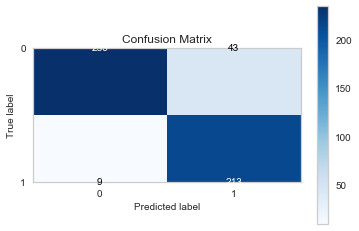

In [17]:
skplt.metrics.plot_confusion_matrix(predictions, target_test)